## teacher_net create

In [1]:
# -*- coding: utf-8 -*-

# Import necessary packages.
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image, ImageEnhance, ImageOps
import random
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset
from torchvision.datasets import DatasetFolder
import torch
# This is for the progress bar.
from tqdm.auto import tqdm
from autoaugment import *

train_tfm = transforms.Compose([
    transforms.RandomResizedCrop(224), 
    transforms.RandomHorizontalFlip(), 
    ImageNetPolicy(), 
    transforms.ToTensor(),
])


# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 32

# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = DatasetFolder("food-11/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
valid_set = DatasetFolder("food-11/validation", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
new_valid_set = DatasetFolder("food-11/validation", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
unlabeled_set = DatasetFolder("food-11/training/unlabeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
new_test_set = DatasetFolder("food-11/testing", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
test_set = DatasetFolder("food-11/testing", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

# Construct data loaders.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


from torch.utils.data import Dataset

class PseudoDataset(Dataset):
    def __init__(self, x, y, transform = None):
        self.data = x
        self.label = y
        self.transform = transform

    def __getitem__(self, idx):
      if self.transform:
        image = self.transform(self.data[idx])
      else:
        image = self.data[idx]

      return image, self.label[idx]

    def __len__(self):
        return len(self.data)

def get_pseudo_labels(dataset, model, threshold=0.9):
    # This functions generates pseudo-labels of a dataset using given model.
    # It returns an instance of DatasetFolder containing images whose prediction confidences exceed a given threshold.
    # You are NOT allowed to use any models trained on external data for pseudo-labeling.
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Construct a data loader.
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Make sure the model is in eval mode.
    model.eval()
    model = model.to(device)
    # Define softmax function.
    softmax = nn.Softmax(dim=-1)

    pseudo_label = torch.tensor([]).to(device)
    target = torch.tensor([]).to(device)
    image = torch.tensor([]).to(device)
    

    # Iterate over the dataset by batches.
    for batch in tqdm(data_loader):
        img, _ = batch
        image = torch.cat((image, img.to(device)))
        
        # Forward the data
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(img.to(device))

        # Obtain the probability distributions by applying softmax on logits.
        probs = softmax(logits)
        max_probs, relabel_class = torch.max(probs, dim=1)#找出每個圖片機率最大的及其類別
        pseudo_label = torch.cat((pseudo_label, relabel_class))
        temp = max_probs.ge(threshold).int()#檢查大於等於threshold的圖片
        target = torch.cat((target, temp))

    # # Turn off the eval mode.
    new_target = target.int()
    new_pseudo = pseudo_label.int()
    temp = []
    pseudo_label_list = new_pseudo.tolist()
    final_img = torch.tensor([]).to(device)
    
    #將大於threshold之圖片與pseudo label取出
    for idx in range(len(new_target)):
      if new_target[idx] == 1:
        temp.append(pseudo_label_list[idx])
        final_img = torch.cat((final_img, image[idx]))
    

    if len(temp) != 0:
      fin_img = final_img.view(-1, 3, 224, 224).to('cpu')
      dataset = PseudoDataset(fin_img, temp)
    
    model.train()
    
    return dataset



In [2]:
class StudentNet(nn.Module):
    def __init__(self):
        super(StudentNet, self).__init__()

        # ---------- TODO ----------
        # Modify your model architecture

        self.cnn = nn.Sequential(
        nn.Conv2d(3, 32, 3), 
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32, 32, 3),  
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2, 2, 0),     

        nn.Conv2d(32, 64, 3), 
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2, 2, 0),     

        nn.Conv2d(64, 100, 3), 
        nn.BatchNorm2d(100),
        nn.ReLU(),
        nn.MaxPool2d(2, 2, 0),

        # Here we adopt Global Average Pooling for various input size.
        nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.fc = nn.Sequential(
        nn.Linear(100, 11),
        )
      
    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)


In [3]:
"""**Create Model & Training Block**"""

import torchvision.models as models
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"
teacher_model_path = './teacher_model.ckpt' #0
last_path = './last_model.ckpt'

fin_best_acc = 0.0
fin_best_path = './teacher_model.ckpt'
fin_model = 0
# model = models.resnet18(pretrained=False)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 11)

model = StudentNet()

opt1 = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)
best_acc = 0.0

In [4]:
def train(n_epochs, model, train_loader, model_path, last_path, optimizer, unlabeled_set = unlabeled_set):
  criterion = nn.CrossEntropyLoss()
  device = "cuda" if torch.cuda.is_available() else "cpu"
  model = model.to(device)
  best_acc = 0.0
  
  for epoch in range(n_epochs):
      # ---------- Training ----------
      # Make sure the model is in train mode before training.
      model.train()

      # These are used to record information in training.
      train_loss = []
      train_accs = []

      # Iterate the training set by batches.

      for batch in tqdm(train_loader):
          # A batch consists of image data and corresponding labels.
          imgs, labels = batch

          # Forward the data. (Make sure data and model are on the same device.)
          logits = model(imgs.to(device))

          # Calculate the cross-entropy loss.
          # We don't need to apply softmax before computing cross-entropy as it is done automatically.
          loss = criterion(logits, labels.to(device))

          # Gradients stored in the parameters in the previous step should be cleared out first.
          optimizer.zero_grad()

          # Compute the gradients for parameters.
          loss.backward()

          # Clip the gradient norms for stable training.
          grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

          # Update the parameters with computed gradients.
          optimizer.step()

          # Compute the accuracy for current batch.
          acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

          # Record the loss and accuracy.
          train_loss.append(loss.item())
          train_accs.append(acc)

      # The average loss and accuracy of the training set is the average of the recorded values.
      train_loss = sum(train_loss) / len(train_loss)
      train_acc = sum(train_accs) / len(train_accs)

      # Print the information.
      print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

      # ---------- Validation ----------
      # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
      model.eval()

      # These are used to record information in validation.
      valid_loss = []
      valid_accs = []

      # Iterate the validation set by batches.
      for batch in tqdm(valid_loader):

          # A batch consists of image data and corresponding labels.
          imgs, labels = batch
          
          # We don't need gradient in validation.
          # Using torch.no_grad() accelerates the forward process.
          with torch.no_grad():
            logits = model(imgs.to(device))

          # We can still compute the loss (but not the gradient).
          loss = criterion(logits, labels.to(device))

          # Compute the accuracy for current batch.
          acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

          # Record the loss and accuracy.
          valid_loss.append(loss.item())
          valid_accs.append(acc)

      # The average loss and accuracy for entire validation set is the average of the recorded values.
      valid_loss = sum(valid_loss) / len(valid_loss)
      valid_acc = sum(valid_accs) / len(valid_accs)

      if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), model_path)
        print('saving model with acc {:.3f}'.format(sum(valid_accs) / len(valid_accs)))

      if epoch == n_epochs-1:
        torch.save(model.state_dict(), last_path)
        print('saving model with acc {:.3f}'.format(sum(valid_accs) / len(valid_accs))) 

      # Print the information.
      print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")



best_flag = train(n_epochs = 200, model = model, train_loader = train_loader, model_path = teacher_model_path, last_path = last_path, optimizer = opt1, unlabeled_set = unlabeled_set)

del model
model = StudentNet()
model.load_state_dict(torch.load(last_path))

concat_dataset = ConcatDataset([train_set, new_valid_set])
train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
opt2 = torch.optim.Adam(model.parameters(), lr=2e-5, weight_decay=1e-4)
best_flag = train(n_epochs = 70, model = model, train_loader = train_loader, model_path = teacher_model_path, last_path = last_path, optimizer = opt2, unlabeled_set = unlabeled_set)

del model
model = StudentNet()
model.load_state_dict(torch.load(last_path))

pseudo_set = get_pseudo_labels(unlabeled_set, model)
concat_dataset = ConcatDataset([train_set, pseudo_set])
train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
opt3 = torch.optim.Adam(model.parameters(), lr=5e-6, weight_decay=1e-4)
best_flag = train(n_epochs = 30, model = model, train_loader = train_loader, model_path = teacher_model_path, last_path = last_path, optimizer = opt3, unlabeled_set = unlabeled_set)


device = "cuda" if torch.cuda.is_available() else "cpu"


del model
model = StudentNet()
model.load_state_dict(torch.load(last_path))

model.eval()


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 001/200 ] loss = 2.30647, acc = 0.17397


  0%|          | 0/21 [00:00<?, ?it/s]

saving model with acc 0.196
[ Valid | 001/200 ] loss = 2.20030, acc = 0.19613


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 002/200 ] loss = 2.23446, acc = 0.21166


  0%|          | 0/21 [00:00<?, ?it/s]

saving model with acc 0.266
[ Valid | 002/200 ] loss = 2.10581, acc = 0.26607


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 003/200 ] loss = 2.19686, acc = 0.23582


  0%|          | 0/21 [00:00<?, ?it/s]

saving model with acc 0.283
[ Valid | 003/200 ] loss = 2.05072, acc = 0.28304


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 004/200 ] loss = 2.17436, acc = 0.23260


  0%|          | 0/21 [00:00<?, ?it/s]

[ Valid | 004/200 ] loss = 2.03617, acc = 0.27589


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 005/200 ] loss = 2.15940, acc = 0.23196


  0%|          | 0/21 [00:00<?, ?it/s]

[ Valid | 005/200 ] loss = 2.06531, acc = 0.24881


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 006/200 ] loss = 2.13763, acc = 0.25193


  0%|          | 0/21 [00:00<?, ?it/s]

saving model with acc 0.285
[ Valid | 006/200 ] loss = 2.00526, acc = 0.28482


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 007/200 ] loss = 2.11568, acc = 0.25644


  0%|          | 0/21 [00:00<?, ?it/s]

saving model with acc 0.295
[ Valid | 007/200 ] loss = 1.99167, acc = 0.29494


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 008/200 ] loss = 2.10884, acc = 0.25805


  0%|          | 0/21 [00:00<?, ?it/s]

saving model with acc 0.318
[ Valid | 008/200 ] loss = 1.95728, acc = 0.31756


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 009/200 ] loss = 2.07819, acc = 0.27094


  0%|          | 0/21 [00:00<?, ?it/s]

[ Valid | 009/200 ] loss = 1.95440, acc = 0.29940


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 010/200 ] loss = 2.06983, acc = 0.27996


  0%|          | 0/21 [00:00<?, ?it/s]

saving model with acc 0.335
[ Valid | 010/200 ] loss = 1.89749, acc = 0.33542


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 011/200 ] loss = 2.05553, acc = 0.27867


  0%|          | 0/21 [00:00<?, ?it/s]

[ Valid | 011/200 ] loss = 1.94993, acc = 0.29435


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 012/200 ] loss = 2.04825, acc = 0.28963


  0%|          | 0/21 [00:00<?, ?it/s]

[ Valid | 012/200 ] loss = 1.90414, acc = 0.33482


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 013/200 ] loss = 2.02950, acc = 0.29575


  0%|          | 0/21 [00:00<?, ?it/s]

[ Valid | 013/200 ] loss = 1.95733, acc = 0.31042


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 014/200 ] loss = 2.03719, acc = 0.28351


  0%|          | 0/21 [00:00<?, ?it/s]

[ Valid | 014/200 ] loss = 1.93024, acc = 0.31161


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 015/200 ] loss = 2.03118, acc = 0.28479


  0%|          | 0/21 [00:00<?, ?it/s]

[ Valid | 015/200 ] loss = 1.93576, acc = 0.28810


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 016/200 ] loss = 2.00890, acc = 0.29027


  0%|          | 0/21 [00:00<?, ?it/s]

[ Valid | 016/200 ] loss = 1.91651, acc = 0.30982


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 017/200 ] loss = 2.00038, acc = 0.29349


  0%|          | 0/21 [00:00<?, ?it/s]

[ Valid | 017/200 ] loss = 1.91441, acc = 0.33482


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 018/200 ] loss = 2.00279, acc = 0.30219


  0%|          | 0/21 [00:00<?, ?it/s]

saving model with acc 0.355
[ Valid | 018/200 ] loss = 1.83227, acc = 0.35476


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 019/200 ] loss = 1.99897, acc = 0.31411


  0%|          | 0/21 [00:00<?, ?it/s]

[ Valid | 019/200 ] loss = 1.83594, acc = 0.35179


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 020/200 ] loss = 1.97309, acc = 0.30831


  0%|          | 0/21 [00:00<?, ?it/s]

[ Valid | 020/200 ] loss = 1.89732, acc = 0.33988


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 021/200 ] loss = 1.98353, acc = 0.31443


  0%|          | 0/21 [00:00<?, ?it/s]

[ Valid | 021/200 ] loss = 1.91599, acc = 0.31310


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 022/200 ] loss = 1.97305, acc = 0.31733


  0%|          | 0/21 [00:00<?, ?it/s]

[ Valid | 022/200 ] loss = 1.81665, acc = 0.34702


  0%|          | 0/97 [00:00<?, ?it/s]

Exception ignored in: <function tqdm.__del__ at 0x7f0966ddf9d0>
Traceback (most recent call last):
  File "/home/leyan/anaconda3/envs/torch_1_21/lib/python3.8/site-packages/tqdm/std.py", line 1161, in __del__
    def __del__(self):
KeyboardInterrupt: 

KeyboardInterrupt



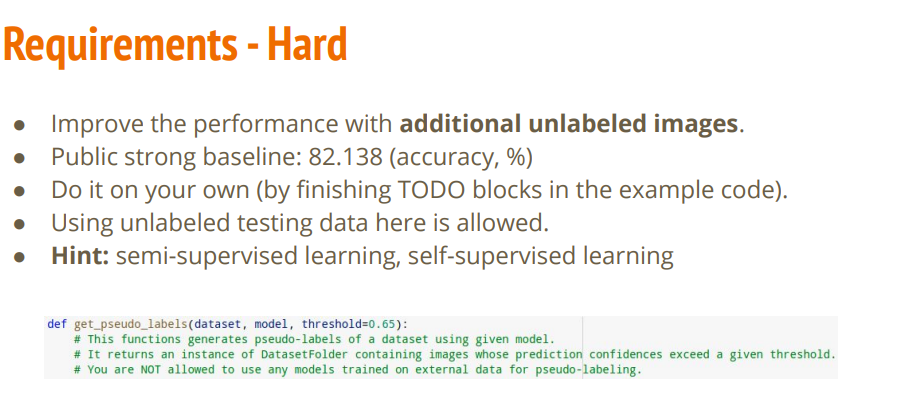

In [10]:
!jupyter nbconvert teacher_net.ipynb --to python

[NbConvertApp] Converting notebook teacher_net.ipynb to python
[NbConvertApp] Writing 11714 bytes to teacher_net.py
